In [1]:
import numpy as np
from iminuit import Minuit

import constants, functions

from functools import partial

from joblib import Parallel, delayed

from numba import njit

from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from time import time

In [7]:
z_data = np.asarray(constants.z_data)
fs8_data = np.asarray(constants.fs8_data)
fs8_err_plus = np.asarray(constants.fs8_err_plus)
fs8_err_minus = np.asarray(constants.fs8_err_minus)

z_data_panth = np.asarray(constants.z_data_panth)
is_calibrator_panth = np.asarray(constants.is_calibrator_panth)
m_b_corr_panth = np.asarray(constants.m_b_corr_panth)
ceph_dist_panth = np.asarray(constants.ceph_dist_panth)
inv_cov_panth = np.asarray(constants.inv_cov_panth)
n_panth = constants.n_panth
c = constants.C

@njit
def chi2_rsd_panth(z_data, fs8_data, fs8_err_plus, fs8_err_minus, n_panth, z_data_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, omega, sigma, gamma, H0, M, c):
    return functions.chi2_panth(n_panth, z_data_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, omega, H0, M, c)


chi2_func = partial(
    chi2_rsd_panth,
    z_data,
    fs8_data,
    fs8_err_plus,
    fs8_err_minus,
    n_panth,
    z_data_panth,
    is_calibrator_panth,
    m_b_corr_panth,
    ceph_dist_panth,
    inv_cov_panth
)

n_om = 100
om_min = .05
om_max = 1

n_s8 = 2
s8_min = 0.4
s8_max = 1.2

n_gamma = 100
gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))


In [ ]:
def chi2_om_s8_func(omega, sigma, gamma_min, gamma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, sigma=sigma, gamma=0.55, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    minimizer.limits["H0"] = (0, 200)
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(omega, gamma, sigma_min, sigma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, gamma=gamma, sigma=0.7, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["omega"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["sigma"] = (sigma_min, sigma_max)
    minimizer.limits["H0"] = (0, 200)
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(sigma, gamma, omega_min, omega_max, chi2_func):
    minimizer = Minuit(chi2_func, sigma=sigma, gamma=gamma, omega=0.3, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["sigma"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["omega"] = (omega_min, omega_max)
    minimizer.limits["H0"] = (0, 200)
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

t = time()
chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(omega, sigma, gamma_min, gamma_max, chi2_func) for omega in omega_vals for sigma in sigma_vals)
chi2_grid1 = np.array(chi2_om_sig8).reshape(n_om, n_s8)
t = time() - t
print("chi2_grid 1 calculated in", int(t//60), "min", round(t%60,1), "s.")

chi2_grid 1 calculated in 0 min 11.8 s.


### Confidence contours plot

(0.4, 0.35707070707070704)
Incertitude $\sigma_8$ : xmin = 0.40, xmax = 1.20 : (+0.0, -0.8)
Incertitude $\Omega_m$ : ymin = 0.33, ymax = 0.38 : (+0.03, -0.02)



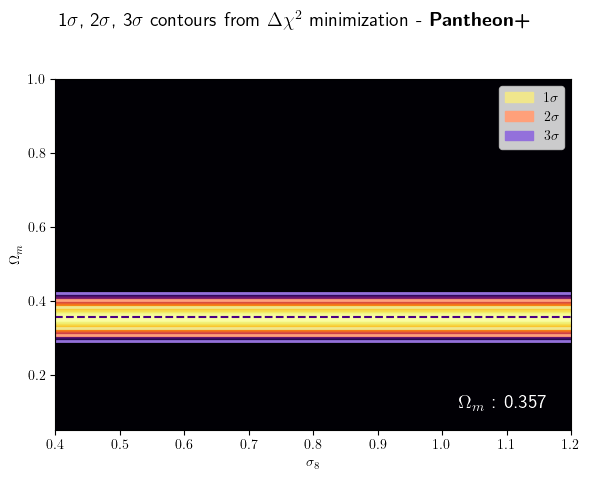

In [17]:
def display_one_chi2(chi2_grid, ax, axis):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$\sigma_8$', r'$\Omega_m$'),
        (r'$\gamma$', r'$\Omega_m$'),
        (r'$\gamma$', r'$\sigma_8$')
    ]

    sigma_vals = np.asarray(np.linspace(s8_min, s8_max, chi2_grid.shape[1]))
    omega_vals = np.asarray(np.linspace(om_min, om_max, chi2_grid.shape[0]))
    gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, chi2_grid.shape[0]))

    if axis == 0:
        X, Y = np.meshgrid(sigma_vals, omega_vals)
    elif axis == 1:
        X, Y = np.meshgrid(gamma_vals, omega_vals)
    elif axis == 2:
        X, Y = np.meshgrid(gamma_vals, sigma_vals)

    chi2_min = np.min(chi2_grid)
    delta_chi2 = chi2_grid - chi2_min
    delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])

    cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
    for level, color in zip(levels, colors):
        cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

        if level == 2.3:
            mask = delta_chi2 <= level
            x_coords = X[mask]
            y_coords = Y[mask]

            xmin, xmax = np.min(x_coords), np.max(x_coords)
            ymin, ymax = np.min(y_coords), np.max(y_coords)

    legend_handles = [
        Patch(color='khaki', label=r'$1\sigma$'),
        Patch(color='lightsalmon', label=r'$2\sigma$'),
        Patch(color='mediumpurple', label=r'$3\sigma$')
    ]
    ax.legend(handles=legend_handles, loc='upper right')

    min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
    x_min = X[min_idx]
    y_min = Y[min_idx]
    ax.axhline(y_min, color='indigo', linestyle='--')
    ax.axvline(x_min, color='indigo', linestyle='--')

    print((x_min, y_min))
    xlabel, ylabel = axes_titles[axis]
    print(f"Incertitude {xlabel} : xmin = {xmin:.2f}, xmax = {xmax:.2f} : (+{round(x_min - xmin, 2)}, -{round(xmax - x_min, 2)})")
    print(f"Incertitude {ylabel} : ymin = {ymin:.2f}, ymax = {ymax:.2f} : (+{round(y_min - ymin, 2)}, -{round(ymax - y_min, 2)})\n")

    latex_text = fr"{ylabel} : {y_min:.3f}"
    ax.text(0.78, 0.1, latex_text, transform=ax.transAxes, color="white", fontsize=14,
            verticalalignment='top', horizontalalignment='left')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_facecolor('black')

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.rcParams.update({"text.usetex": True})
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization - $\textbf{Pantheon+}$", fontsize=14)
display_one_chi2(chi2_grid1, ax, axis=0)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
